# Exercise - Smart Routing System - SOLUTION

In this exercise, you will implement a comprehensive routing system that combines all three routing patterns we learned:
1. **Priority-Based Routing** - Assess urgency first
2. **Content-Based Routing** - Route to appropriate team based on topic
3. **Round-Robin Routing** - Distribute work evenly within each team


**Challenge**

You're building a customer support system for **FinTechCorp**, a financial technology company. The system needs to intelligently route customer inquiries to the right team and agent.


Your solution should:
1. **First**: Classify urgency (urgent vs. normal)
2. **Second**: Classify topic (credit_card, account, loan, general)
3. **Third**: Route to appropriate team
4. **Fourth**: Use round-robin to assign to available agents within that team

**Teams & Specializations:**
- **General Support Team**: Basic product questions, account setup, general inquiries
- **Credit Card Team**: Credit card issues, disputes, fraud, rewards
- **Account Team**: Account access, security, verification, settings
- **Loan Team**: Loan applications, payments, refinancing, documentation


## 0. Setup

In [1]:
import os
from typing import Dict, Any, List, Literal
from IPython.display import Image, display
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_API_KEY")
)

## 1. Classification functions

Create classification functions that determine the urgency and topic of customer inquiries. These functions will be used to route messages to the appropriate teams.

In [ ]:
# TODO: Create UrgencyClassification model
# that classifies messages as "urgent" or "normal"
# Field: urgency
class UrgencyClassification(BaseModel):
    pass

In [ ]:
# TODO: Create TopicClassification model
#  that classifies messages into categories: 
# "credit_card", "account", "loan", or "general" 
# based on content analysis.
# Field: topic
class TopicClassification(BaseModel):
    pass

In [ ]:
# TODO: Implement urgency classification
# using with_structured_output method
def classify_urgency(text: str) -> str:
    """Classify the urgency level of a customer inquiry."""
    pass

In [ ]:
# TODO: Implement urgency classification
# using with_structured_output method
def classify_topic(text: str) -> str:
    """Classify the topic/category of a customer inquiry."""
    pass

## 2. Agent Pools

Create specialized agent pools for each support team. Each team should have multiple agents to enable round-robin distribution.

In [8]:
# General Support Team (3 agents)
general_agents_pool = [
    create_react_agent(
        name=f"general_agent_{i}",
        prompt=SystemMessage(
            content=(
                f"You are General Support Agent {i} at FinTechCorp. "
                "Handle basic product questions, account setup, and general inquiries. "
                "ALWAYS start with '[GENERAL SUPPORT]' and be helpful!"
            )
        ),
        model=llm,
        tools=[],
    ) for i in range(1, 4)
]

In [9]:
# Credit Card Team (2 agents)  
credit_card_agents_pool = [
    create_react_agent(
        name=f"credit_card_agent_{i}",
        prompt=SystemMessage(
            content=(
                f"You are Credit Card Specialist {i} at FinTechCorp. "
                "Handle credit card issues, disputes, fraud, and rewards. "
                "ALWAYS start with '[CREDIT CARD]' and be professional!"
            )
        ),
        model=llm,
        tools=[],
    ) for i in range(1, 3)
]

In [10]:
# Account Team (2 agents)
account_agents_pool = [
    create_react_agent(
        name=f"account_agent_{i}",
        prompt=SystemMessage(
            content=(
                f"You are Account Specialist {i} at FinTechCorp. "
                "Handle account access, security, verification, and settings. "
                "ALWAYS start with '[ACCOUNT]' and be security-focused!"
            )
        ),
        model=llm,
        tools=[],
    ) for i in range(1, 3)
]

In [11]:
# Loan Team (2 agents)
loan_agents_pool = [
    create_react_agent(
        name=f"loan_agent_{i}",
        prompt=SystemMessage(
            content=(
                f"You are Loan Specialist {i} at FinTechCorp. "
                "Handle loan applications, payments, refinancing, and documentation. "
                "ALWAYS start with '[LOAN]' and be thorough!"
            )
        ),
        model=llm,
        tools=[],
    ) for i in range(1, 3)
]

In [ ]:
# TODO: Create a dictionary mapping team names to their respective agent pools.
agent_swarm_map = {}

## 3. Round-robin: Team Subgraphs

Implement round-robin routing within each team to distribute work evenly among available agents.

In [13]:
class RoundRobinState(MessagesState):
    """State that tracks which agent to call next."""
    agent_names: List[str]
    current_agent_index: int

In [14]:
def update_index(state: RoundRobinState):
    agent_names = state["agent_names"]
    current_agent_index = state.get("current_agent_index", 0)
    new_agent_index = current_agent_index + 1  
    new_agent_index_in_range = new_agent_index % len(agent_names)
    return {
        "current_agent_index": new_agent_index_in_range
    }

In [15]:
def route_round_robin(state: RoundRobinState):
    """Route tasks in round-robin fashion."""
    agent_names = state["agent_names"]
    current_agent_index = state.get("current_agent_index", 0)
    current_agent_index_in_range = current_agent_index % len(agent_names)
    active_agent = agent_names[current_agent_index_in_range]
    print("Round-robin Active Agent:", active_agent)
    return active_agent

In [16]:
def create_team(name:str, agent_pool:List[CompiledStateGraph]):
    workflow = StateGraph(RoundRobinState)

    workflow.add_node("update_index", update_index)
    for agent in agent_pool:
        workflow.add_node(agent.name, agent)

    workflow.add_edge(START, "update_index")

    workflow.add_conditional_edges(
        source="update_index",
        path=route_round_robin,
        path_map=[agent.name for agent in agent_pool]
    )

    graph = workflow.compile(name=name, checkpointer=MemorySaver())

    return graph

In [ ]:
# TODO: Create all team subgraphs using the create_team function.
agent_teams = []

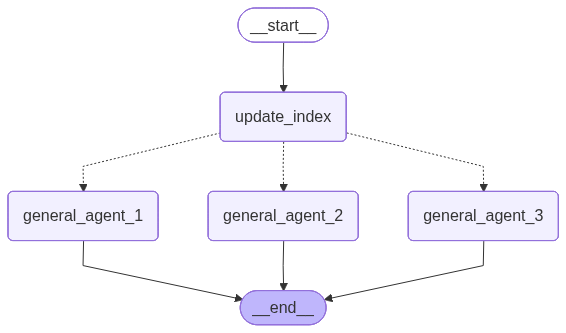

In [18]:
agent_teams[0]

## 4. Workflow Assembly

Assemble the complete routing workflow that combines urgency classification, topic classification, and team routing.

In [19]:
class FintechState(MessagesState):
    """State that tracks which team to call next within each team."""
    query: str
    agent_teams: List[CompiledStateGraph]
    agent_swarm_map: Dict[str, CompiledStateGraph]
    team_to_call: str

In [ ]:
def define_agent_team(state: FintechState):
    query = state["query"]
    
    # TODO: classify urgency
    urgency = ...
    
    # TODO: Then classify topic
    topic = ...
    
    # Define based on urgency + topic combination
    if urgency == "urgent":
        # Urgent issues go to specialized teams
        if topic == "credit_card":
            return {"team_to_call": "credit_card_team"}
        elif topic == "account":
            return {"team_to_call": "account_team"}
        elif topic == "loan":
            return {"team_to_call": "loan_team"}

    return {"team_to_call": "general_team"}


In [ ]:
def trigger_agent_team(state: FintechState, config: RunnableConfig):
    query = state["query"]
    team_to_call = state["team_to_call"]
    agent_teams:List[CompiledStateGraph] = config["configurable"]["agent_teams"]
    agent_swarm_map = config["configurable"]["agent_swarm_map"]
    agent_pool_to_call:List[CompiledStateGraph] = agent_swarm_map[team_to_call]

    for team in agent_teams:
        if team.name == team_to_call:
            
            result = team.invoke(
                input={
                    "messages": [HumanMessage(content=query)],
                    "agent_names": [agent.name for agent in agent_pool_to_call]
                },
                config={
                    "configurable": {
                        "thread_id": "round_robin"
                    }
                }
            )
            return {"messages": result["messages"]} 
 
    raise ValueError("team_to_call is not inside agent_teams")  

In [22]:
def create_fintech_workflow():
    """
    Create the complete workflow that:
    1. Routes by urgency + topic to teams
    2. Uses round-robin within teams
    """
    workflow = StateGraph(FintechState)
    
    workflow.add_node("define_agent_team", define_agent_team)
    workflow.add_node("trigger_agent_team", trigger_agent_team)
    
    workflow.add_edge(START, "define_agent_team")
    workflow.add_edge("define_agent_team", "trigger_agent_team")
    workflow.add_edge("trigger_agent_team", END)
    
    return workflow

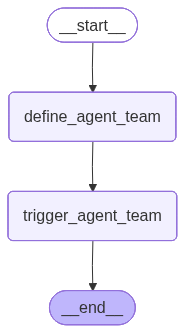

In [23]:
fintech_workflow = create_fintech_workflow()
fintech_graph = fintech_workflow.compile(checkpointer=MemorySaver())
fintech_graph

## 5. Run Multi Agent System

Create a function to execute the complete routing system and test it with various customer inquiries.

In [24]:
def run_multi_agent_system(
    query:str,
    graph:CompiledStateGraph, 
    thread_id:str,
    agent_teams:List[CompiledStateGraph],
    agent_swarm_map:Dict[str, CompiledStateGraph]
):
    result = graph.invoke(
        input={
            "query": query,
        },
        config={
            "configurable": {
                "thread_id": thread_id,
                "agent_teams": agent_teams,
                "agent_swarm_map": agent_swarm_map,
            }
        }
    )
    return result

In [ ]:
# TODO: Pass the arguments and run your system
result = run_multi_agent_system()

general_team credit_card_team
credit_card_team credit_card_team
Round-robin Active Agent: credit_card_agent_2


In [27]:
result

{'messages': [HumanMessage(content='URGENT: My credit card was stolen!', additional_kwargs={}, response_metadata={}, id='7a955af6-dbca-4100-83b4-b75e56bbcde1'),
  AIMessage(content="[CREDIT CARD] I'm sorry to hear that your credit card was stolen. It's important to act quickly to protect your account. Please follow these steps:\n\n1. **Report the Theft**: Call our customer service immediately at [insert customer service number] to report the stolen card. We will block your card to prevent any unauthorized transactions.\n\n2. **Review Transactions**: Check your recent transactions for any unauthorized charges. Make a note of any suspicious activity to report.\n\n3. **Request a Replacement Card**: Once your card is reported stolen, we can issue a replacement card for you.\n\n4. **Monitor Your Account**: Keep an eye on your account for any further unauthorized transactions and report them as soon as possible.\n\nIf you need further assistance or have any questions, please let me know!", a

In [31]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

URGENT: My credit card was stolen!
================================== Ai Message ==================================
Name: credit_card_agent_2

[CREDIT CARD] I'm sorry to hear that your credit card was stolen. It's important to act quickly to protect your account. Please follow these steps:

1. **Report the Theft**: Call our customer service immediately at [insert customer service number] to report the stolen card. We will block your card to prevent any unauthorized transactions.

2. **Review Transactions**: Check your recent transactions for any unauthorized charges. Make a note of any suspicious activity to report.

3. **Request a Replacement Card**: Once your card is reported stolen, we can issue a replacement card for you.

4. **Monitor Your Account**: Keep an eye on your account for any further unauthorized transactions and report them as soon as possible.

If you need further assistance or have any q

## 6. [Optional] Test Cases

Create comprehensive test cases to validate the routing system works correctly across different scenarios.

In [ ]:
test_cases = [
    # (message, expected_team, expected_urgency)
    ("How do I check my account balance?", "general_team", "normal"),
    ("URGENT: My credit card was stolen!", "credit_card_team", "urgent"),
    ("I can't access my account, this is critical", "account_team", "urgent"),
    ("What are the current loan rates?", "loan_team", "normal"),
    ("ASAP: Fraudulent charges on my card!", "credit_card_team", "urgent"),
    ("How do I update my contact information?", "account_team", "normal"),
    ("I need help with my loan application", "loan_team", "normal"),
    ("What products do you offer?", "general_team", "normal"),
]